In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import traceback

# --- EDIT THESE PATHS ---
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN"
BUTLER_REPO = "/repo/main"                     # <-- edit if needed
COLLECTION = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"
WHERE = "instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))"

# --- Import your project code ---
import sys
sys.path.insert(0, REPO_ROOT)

# You said your functions live in ADCNN/data/dataset_creation/common.py
from ADCNN.data.dataset_creation.common import (
    psf_fit_flux_sigma,
    snr_to_mag,          # if you want to use it
)

# If you have your injection/simulation entrypoint, import it here.
# Example placeholders - YOU MUST EDIT to match your real code.
# from ADCNN.data.dataset_creation.simulate_inject import simulate_and_measure

# Butler / LSST
import lsst.daf.butler as dafButler

butler = dafButler.Butler(BUTLER_REPO)

def get_calexp_for_row(row):
    """
    EDIT THIS to match your notebook’s working version.
    Must return (calexp, datasetRef or None).
    """
    visit = int(row["visit"])
    det = int(row["detector"])
    # Example:
    ref = butler.get("preliminary_visit_image", instrument="LSSTComCam", visit=visit, detector=det, collections=COLLECTION)
    return ref, None

def snr_from_magerr(mag_err):
    # Verified by you: stack_snr = 1.0857 / mag_err
    return 1.0857 / np.asarray(mag_err, dtype=float)

def binned_median(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    out = []
    for i in range(len(bins)-1):
        m = (x >= bins[i]) & (x < bins[i+1]) & np.isfinite(y)
        if np.any(m):
            out.append(((bins[i]+bins[i+1])/2, np.median(y[m]), np.sum(m)))
    return np.array(out, float)


In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER EDIT: set these two paths ---
CSV_PATH = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/Notebooks/SNR_tests/test.csv"  # your injection catalog
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/"  # e.g. "/sdf/home/m/mrakovci/rubin-user/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation"
# If you run the notebook from the repo already, leave REPO_ROOT=None.

# Add repo to sys.path so we can import your common.py
if REPO_ROOT is not None:
    rr = Path(REPO_ROOT).resolve()
    if str(rr) not in sys.path:
        sys.path.insert(0, str(rr))

sys.path.insert(0, "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation")
# Import your estimators from common.py (the functions you added)
from ADCNN.data.dataset_creation.simulate_inject import *

# LSST imports (must be in an environment where lsst_distrib is set up)
import lsst.daf.butler as dafButler
import lsst.geom as geom


In [8]:
import concurrent.futures
import pandas as pd
import numpy as np
from lsst.daf.butler import Butler

def worker_df(args):
    """
    Runs one_detector_injection for a single (visit,detector) and returns a pandas DataFrame.
    No H5, no CSV. Only catalog.
    """
    (
        dataId, repo, coll, dims, number, trail_length, magnitude, beta,
        source_type, global_seed, mag_mode, psf_template
    ) = args

    seed = (int(global_seed) * 1_000_003 + int(dataId["visit"]) * 1_003 + int(dataId["detector"])) & 0xFFFFFFFF

    res = one_detector_injection(
        number, trail_length, magnitude, beta,
        repo, coll, dims, source_type, dataId, seed,
        mag_mode=mag_mode, psf_template=psf_template,
        debug=False,
    )

    # res is either (False, dataId, err, tb) or (True, img, mask, real_labels, injection_catalog)
    if res[0] is False:
        _, bad_dataId, err, tb = res
        # Return empty df but keep error info for debugging if you want
        return ("err", bad_dataId, err, tb, None)

    _, img, mask, real_labels, catalog = res
    df = catalog.to_pandas()
    # keep provenance columns
    df["visit"] = int(dataId["visit"])
    df["detector"] = int(dataId["detector"])
    return ("ok", dataId, None, None, df)


def run_parallel_injection_df(
    repo, coll, where,
    number, trail_length, magnitude, beta,
    parallel=4, random_subset=0, train_test_split=0, seed=123, test_only=False,
    bad_visits_file=None, mag_mode="psf_mag", psf_template="image",
):
    """
    Like run_parallel_injection(), but returns one concatenated DataFrame and does not write H5/CSV.
    """
    butler = Butler(repo, collections=coll)

    refs = list(set(
        butler.registry.queryDatasets(
            "preliminary_visit_image",
            where=where,
            instrument="LSSTComCam",
            findFirst=True
        )
    ))
    refs = sorted(refs, key=lambda r: int(r.dataId["visit"]) * 1000 + int(r.dataId["detector"]))

    if bad_visits_file is not None:
        bad_df = pd.read_csv(bad_visits_file)
        bad_set = set(zip(bad_df["visit"].astype(int), bad_df["detector"].astype(int)))
        refs = [r for r in refs if (int(r.dataId["visit"]), int(r.dataId["detector"])) not in bad_set]

    if random_subset > 0:
        rng_subset = np.random.default_rng(seed)
        refs = list(rng_subset.choice(refs, random_subset, replace=False))

    # optional train/test split logic preserved (same as your code)
    rng_split = np.random.default_rng(seed + 1)
    test_index = rng_split.choice(
        np.arange(len(refs)),
        int((1 - train_test_split) * len(refs)),
        replace=False
    ) if 0 < train_test_split < 1 else np.array([], dtype=int)

    if test_only:
        refs = [refs[i] for i in test_index]
    else:
        # if not test_only and split requested, keep all refs (you can filter later if you want)
        pass

    dims = butler.get("preliminary_visit_image.dimensions", dataId=refs[0].dataId)

    tasks = []
    for ref in refs:
        tasks.append((
            ref.dataId, repo, coll, dims, number, trail_length, magnitude, beta,
            "preliminary_visit_image", seed, mag_mode, psf_template
        ))

    dfs = []
    errors = []

    if parallel > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=parallel) as ex:
            futs = [ex.submit(worker_df, t) for t in tasks]
            completed = 0
            total = len(futs)

            for fut in concurrent.futures.as_completed(futs):
                completed += 1
                status, dataId, err, tb, df = fut.result()

                if status == "ok":
                    dfs.append(df)
                    print(f"[{completed}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
                else:
                    errors.append((dataId, err, tb))
                    print(f"[{completed}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                    print(err, flush=True)
                    print(tb, flush=True)

    else:
        for i, t in enumerate(tasks, 1):
            status, dataId, err, tb, df = worker_df(t)
            if status == "ok":
                dfs.append(df)
                print(f"[{i}/{len(tasks)}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
            else:
                errors.append((dataId, err, tb))
                print(f"[{i}/{len(tasks)}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                print(err, flush=True)
                print(tb, flush=True)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return out, errors


In [10]:
df, errors = run_parallel_injection_df(
    repo="/repo/main",
    coll="LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530",
    where="instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))",   # <-- adjust
    bad_visits_file="/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation/bad_visits.csv",
    number=100,
    trail_length=[6, 60],
    magnitude=[2, 10],            # used as SNR bounds if mag_mode="snr"
    beta=[0, 0],
    parallel=4,
    random_subset=4,
    train_test_split=0,
    seed=123,
    mag_mode="snr",
    psf_template="image",
)

[1/4] ok visit=2024112300235 det=1
[2/4] ok visit=2024110800278 det=4
[3/4] ok visit=2024110800254 det=5
[4/4] ok visit=2024112400276 det=6


In [11]:
# Basic sanity
needed = ["visit","detector","x","y","trail_length","beta","integrated_mag",
          "stack_detection","stack_mag","stack_mag_err","stack_snr"]
missing = [c for c in needed if c not in df.columns]
print("Missing columns:", missing)
assert len(missing) == 0, "CSV missing required columns."

# Keep only Stack detections
d = df[df["stack_detection"] == True].copy()
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["stack_mag","stack_mag_err","stack_snr","integrated_mag","trail_length","beta","x","y"])
print("Detected rows:", len(d))
d.head()


Missing columns: []
Detected rows: 313


,ra,dec,source_type,trail_length,mag,beta,visit,detector,integrated_mag,PSF_mag,SNR,physical_filter,x,y,stack_detection,stack_mag,stack_mag_err,stack_snr
0,38.240380,7.516627,Trail,45.894635,25.323622,0.0,2024112300235,1,21.169217,21.923558,8.008854,i,849,1408,True,22.800162,0.115368,9.411089
4,38.401858,7.577760,Trail,19.295534,25.267359,0.0,2024112300235,1,22.053717,22.457114,8.098964,i,3668,167,True,22.862217,0.117570,9.234834
6,38.357933,7.519952,Trail,36.532530,25.680381,0.0,2024112300235,1,21.773682,22.426764,5.861355,i,2939,1243,True,23.362633,0.191354,5.673960
7,38.348100,7.373416,Trail,55.966716,25.221286,0.0,2024112300235,1,20.851461,21.707751,9.020159,i,2896,3882,True,22.755955,0.108019,10.051311
8,38.216804,7.580522,Trail,14.950929,25.281901,0.0,2024112300235,1,22.345230,22.665605,7.760991,i,372,283,True,22.842473,0.116843,9.292282


 200 / 200Counts: {'ok': 200}
Check A median ratio stack_snr/(1.0857/mag_err): 1.000033346926526


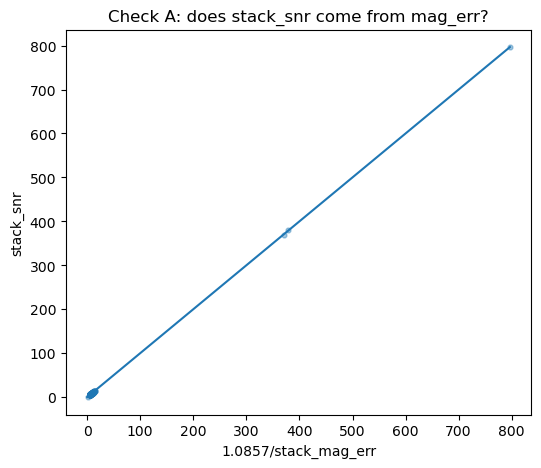

Median sigmaF_model/sigmaF_stack: 4.500450674296502
MAD sigmaF_model/sigmaF_stack: 1.8066406300282838


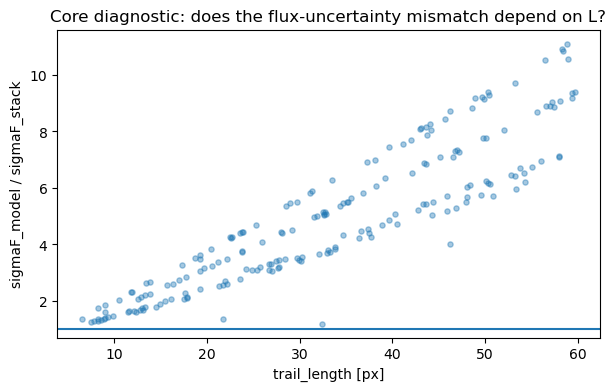

Median (mag_from_stack_snr - stack_mag): -1.6331299230717722
MAD: 0.42044548343061905


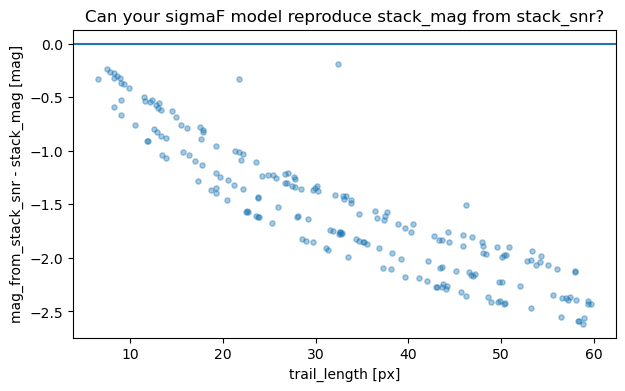

In [23]:
# Sample to keep it cheap (butler I/O)
N = min(200, len(d))
ss = d.sample(n=N, random_state=1).copy()

why = Counter()
rows = []
counter = 0
for idx, row in ss.iterrows():
    try:
        counter+=1
        print (f"\r", counter, "/", len(ss), end="")
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        stack_mag = float(row["stack_mag"])
        stack_mag_err = float(row["stack_mag_err"])
        stack_snr = float(row["stack_snr"])
        integrated_mag = float(row["integrated_mag"])

        # --- Check A: internal consistency ---
        stack_snr_from_err = float(snr_from_magerr(stack_mag_err))

        # --- Convert mags to fluxes (in the same calibration as stack_mag) ---
        F_stack = float(calexp.getPhotoCalib().magnitudeToInstFlux(stack_mag))
        F_int   = float(calexp.getPhotoCalib().magnitudeToInstFlux(integrated_mag))

        # --- Stack-implied flux uncertainty ---
        sigmaF_stack = F_stack / stack_snr

        # --- Your model sigmaF (for a trailed source) ---
        sigmaF_model = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if not np.isfinite(sigmaF_model) or sigmaF_model <= 0:
            why["sigmaF_model_bad"] += 1
            continue

        # --- Your predicted SNR for the injected flux (as you’ve been doing) ---
        snr_raw = F_int / sigmaF_model

        # --- If you want: try to reproduce stack_mag from stack_snr using YOUR sigmaF_model ---
        # This is the “do we reproduce stack_mag?” test you asked for.
        mag_from_stack_snr = snr_to_mag(
            stack_snr, calexp, x0, y0,
            use_kernel_image=True,
            l_pix=L, theta_deg=th,
            pad_sigma=5.0,
        )

        rows.append([
            L, th,
            stack_snr, stack_snr_from_err, stack_mag, stack_mag_err,
            sigmaF_stack, sigmaF_model,
            snr_raw,
            mag_from_stack_snr
        ])
        why["ok"] += 1

    except Exception as e:
        why["exception"] += 1
        # uncomment if you want details:
        print("FAIL idx", idx, "err", repr(e))
        print(traceback.format_exc())
        continue

print("Counts:", dict(why))
if len(rows) == 0:
    raise RuntimeError("No rows survived; check butler access and function imports.")

cols = ["L","beta","stack_snr","snr_from_magerr","stack_mag","stack_mag_err",
        "sigmaF_stack","sigmaF_model","snr_raw","mag_from_stack_snr"]
R = pd.DataFrame(rows, columns=cols)

# ---- Check A plot: stack_snr vs 1.0857/mag_err ----
ratioA = R["stack_snr"] / R["snr_from_magerr"]
print("Check A median ratio stack_snr/(1.0857/mag_err):", np.median(ratioA))

plt.figure(figsize=(6,5))
plt.scatter(R["snr_from_magerr"], R["stack_snr"], s=12, alpha=0.4)
mx = np.nanmax(R[["snr_from_magerr","stack_snr"]].to_numpy())
plt.plot([0,mx],[0,mx])
plt.xlabel("1.0857/stack_mag_err")
plt.ylabel("stack_snr")
plt.title("Check A: does stack_snr come from mag_err?")
plt.show()

# ---- Decisive check: sigmaF_model vs sigmaF_stack ----
ratio_sigmaF = R["sigmaF_model"] / R["sigmaF_stack"]
print("Median sigmaF_model/sigmaF_stack:", np.median(ratio_sigmaF))
print("MAD sigmaF_model/sigmaF_stack:", np.median(np.abs(ratio_sigmaF - np.median(ratio_sigmaF))))

plt.figure(figsize=(7,4))
plt.scatter(R["L"], ratio_sigmaF, s=14, alpha=0.4)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("sigmaF_model / sigmaF_stack")
plt.title("Core diagnostic: does the flux-uncertainty mismatch depend on L?")
plt.show()

# ---- Your requested “reproduce stack_mag from stack_snr” test ----
mag_resid = R["mag_from_stack_snr"] - R["stack_mag"]
print("Median (mag_from_stack_snr - stack_mag):", np.median(mag_resid))
print("MAD:", np.median(np.abs(mag_resid - np.median(mag_resid))))

plt.figure(figsize=(7,4))
plt.scatter(R["L"], mag_resid, s=14, alpha=0.4)
plt.axhline(0.0)
plt.xlabel("trail_length [px]")
plt.ylabel("mag_from_stack_snr - stack_mag [mag]")
plt.title("Can your sigmaF model reproduce stack_mag from stack_snr?")
plt.show()


In [24]:
# Cell 1: minimal helpers (no dependency on your common.py internals)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
import traceback


def _compute_psf_image(calexp, x: float, y: float, use_kernel_image: bool = True) -> np.ndarray | None:
    psf = calexp.getPsf()
    try:
        if use_kernel_image and hasattr(psf, "computeKernelImage"):
            return psf.computeKernelImage(geom.Point2D(float(x), float(y))).array.astype(np.float64)
        return psf.computeImage(geom.Point2D(float(x), float(y))).array.astype(np.float64)
    except Exception:
        return None


def _estimate_sigma_from_psf(phi_unit: np.ndarray) -> float:
    H, W = phi_unit.shape
    yy, xx = np.mgrid[0:H, 0:W]
    tot = float(phi_unit.sum())
    if not np.isfinite(tot) or tot <= 0:
        return np.nan
    cy = float((yy * phi_unit).sum() / tot)
    cx = float((xx * phi_unit).sum() / tot)
    dy = yy - cy
    dx = xx - cx
    m2 = float(((dx * dx + dy * dy) * phi_unit).sum() / tot / 2.0)
    if not np.isfinite(m2) or m2 <= 0:
        return np.nan
    return float(math.sqrt(m2))


def _center_crop_pad(img: np.ndarray, out_shape: tuple[int, int]) -> np.ndarray:
    H, W = out_shape
    out = np.zeros((H, W), dtype=np.float64)

    ih, iw = img.shape
    cy, cx = ih // 2, iw // 2
    oy, ox = H // 2, W // 2

    ys0 = max(0, cy - oy)
    xs0 = max(0, cx - ox)
    ys1 = min(ih, ys0 + H)
    xs1 = min(iw, xs0 + W)

    yd0 = max(0, oy - cy)
    xd0 = max(0, ox - cx)
    yd1 = yd0 + (ys1 - ys0)
    xd1 = xd0 + (xs1 - xs0)

    out[yd0:yd1, xd0:xd1] = img[ys0:ys1, xs0:xs1]
    return out


def _get_psf_stamp_and_var(calexp, x: float, y: float, out_shape: tuple[int, int], use_kernel_image: bool = True):
    psf_img = _compute_psf_image(calexp, x, y, use_kernel_image=use_kernel_image)
    if psf_img is None:
        return None, None

    phi_cut = _center_crop_pad(psf_img.astype(np.float64), out_shape)

    var_full = calexp.variance.array.astype(np.float64)
    Himg, Wimg = var_full.shape

    H, W = out_shape
    cx = int(round(x))
    cy = int(round(y))
    x0 = cx - W // 2
    y0 = cy - H // 2
    x1 = x0 + W
    y1 = y0 + H

    v_cut = np.full((H, W), np.nan, dtype=np.float64)

    ix0 = max(x0, 0)
    iy0 = max(y0, 0)
    ix1 = min(x1, Wimg)
    iy1 = min(y1, Himg)
    if ix0 >= ix1 or iy0 >= iy1:
        return phi_cut, v_cut

    vx0 = ix0 - x0
    vy0 = iy0 - y0
    vx1 = vx0 + (ix1 - ix0)
    vy1 = vy0 + (iy1 - iy0)

    v_cut[vy0:vy1, vx0:vx1] = var_full[iy0:iy1, ix0:ix1]
    return phi_cut, v_cut


In [25]:
# Cell 2: Fourier-shift trail template + sigmaF that uses it

def _fft_shift_from_F(F: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    Shift an image by (dx,dy) in pixels using Fourier shift theorem.
    dx>0 shifts to +x (right), dy>0 shifts to +y (down).
    """
    ph, pw = F.shape
    fy = np.fft.fftfreq(ph)[:, None]  # cycles/pixel
    fx = np.fft.fftfreq(pw)[None, :]
    phase = np.exp(-2j * np.pi * (fx * dx + fy * dy))
    shifted = np.fft.ifft2(F * phase)
    return shifted.real


def _trail_template_for_stamp_fft(
    calexp,
    x: float,
    y: float,
    *,
    L_pix: float,
    theta_deg: float,
    out_shape: tuple[int, int],
    use_kernel_image: bool = True,
    step: float = 0.15,
) -> np.ndarray | None:

    psf_img = _compute_psf_image(calexp, x, y, use_kernel_image=use_kernel_image)
    if psf_img is None:
        return None
    s = float(psf_img.sum())
    if not np.isfinite(s) or s <= 0:
        return None

    psf_unit = (psf_img / s).astype(np.float64)

    # put PSF onto the big stamp ONCE (no repeated resampling)
    ph_big = _center_crop_pad(psf_unit, out_shape)

    H, W = out_shape
    T = np.zeros((H, W), dtype=np.float64)

    theta = math.radians(float(theta_deg))
    ux = math.cos(theta)
    uy = math.sin(theta)

    step = float(step)
    if step <= 0:
        raise ValueError("step must be > 0")

    n = int(math.ceil(L_pix / step)) + 1
    n = max(n, 21)
    s_vals = np.linspace(-0.5 * L_pix, 0.5 * L_pix, n)

    # one FFT for all shifts
    F = np.fft.fft2(ph_big)

    for sv in s_vals:
        dx = float(sv * ux)
        dy = float(sv * uy)
        T += _fft_shift_from_F(F, dx=dx, dy=dy)

    np.maximum(T, 0.0, out=T)
    Ts = float(T.sum())
    if not np.isfinite(Ts) or Ts <= 0:
        return None
    T /= Ts
    return T


def psf_fit_flux_sigma_fft(
    calexp,
    x: float,
    y: float,
    *,
    L_pix: float,
    theta_deg: float,
    use_kernel_image: bool = True,
    pad_sigma: float = 5.0,
    step: float = 0.15,
) -> float:

    psf_native = _compute_psf_image(calexp, x, y, use_kernel_image=use_kernel_image)
    if psf_native is None:
        return np.nan
    psf_sum = float(psf_native.sum())
    if not np.isfinite(psf_sum) or psf_sum <= 0:
        return np.nan

    psf_unit_native = (psf_native / psf_sum).astype(np.float64)
    sigma_pix = _estimate_sigma_from_psf(psf_unit_native)
    if not np.isfinite(sigma_pix) or sigma_pix <= 0:
        return np.nan

    R = int(math.ceil(pad_sigma * sigma_pix))
    R = max(R, 20)
    S = int(math.ceil(L_pix)) + 2 * R + 1
    if S < 33:
        S = 33
    if S % 2 == 0:
        S += 1
    out_shape = (S, S)

    phi_cut, v_cut = _get_psf_stamp_and_var(calexp, x=float(x), y=float(y), out_shape=out_shape, use_kernel_image=use_kernel_image)
    if phi_cut is None or v_cut is None:
        return np.nan

    s = float(np.nansum(phi_cut))
    if not np.isfinite(s) or s <= 0:
        return np.nan
    phi = (phi_cut / s).astype(np.float64)

    T = _trail_template_for_stamp_fft(
        calexp, x=float(x), y=float(y),
        L_pix=float(L_pix), theta_deg=float(theta_deg),
        out_shape=out_shape,
        use_kernel_image=use_kernel_image,
        step=float(step),
    )
    if T is None:
        return np.nan

    good = np.isfinite(v_cut) & (v_cut > 0) & np.isfinite(phi) & np.isfinite(T)
    if not np.any(good):
        return np.nan

    denom_phi = np.sum((phi[good] ** 2) / v_cut[good])
    overlap = np.sum((phi[good] * T[good]) / v_cut[good])

    if not np.isfinite(denom_phi) or denom_phi <= 0 or not np.isfinite(overlap) or overlap <= 0:
        return np.nan

    return float(np.sqrt(denom_phi)) / float(overlap)


200 / 200
Counts: {'ok': 200}
Check A median ratio stack_snr/(1.0857/mag_err): 1.000033346926526
Median sigmaF_cv2/sigmaF_stack: 4.500450674296502
Median sigmaF_fft/sigmaF_stack: 4.487105774945478


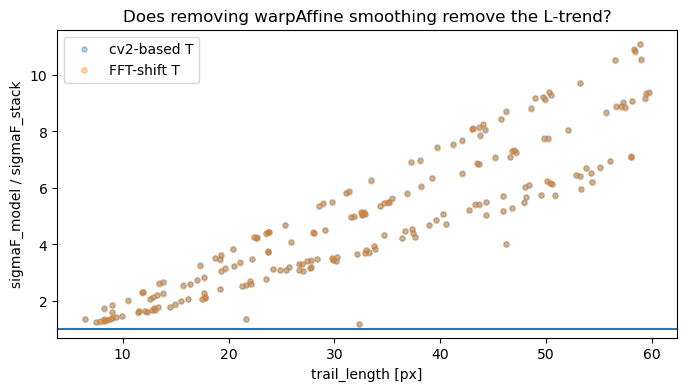

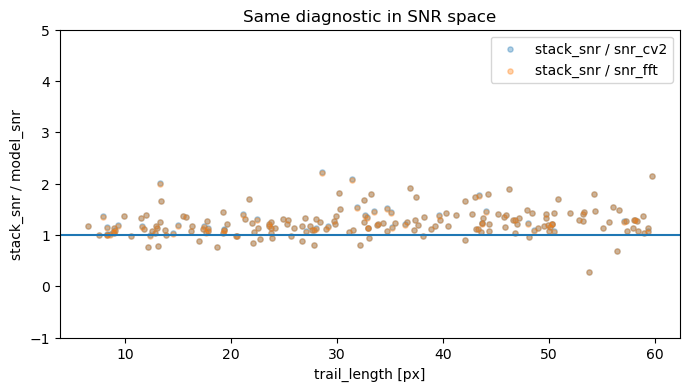

In [27]:
# Cell 3: rerun your diagnostic, side-by-side: (old cv2-based) vs (FFT-based)

N = min(200, len(d))
ss = d.sample(n=N, random_state=1).copy()

why = Counter()
rows = []

counter = 0
for idx, row in ss.iterrows():
    counter += 1
    print(f"\r{counter} / {len(ss)}", end="")

    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        stack_mag = float(row["stack_mag"])
        stack_mag_err = float(row["stack_mag_err"])
        stack_snr = float(row["stack_snr"])
        integrated_mag = float(row["integrated_mag"])

        stack_snr_from_err = float(snr_from_magerr(stack_mag_err))

        F_stack = float(calexp.getPhotoCalib().magnitudeToInstFlux(stack_mag))
        F_int   = float(calexp.getPhotoCalib().magnitudeToInstFlux(integrated_mag))

        sigmaF_stack = F_stack / stack_snr

        # --- your current model (cv2 warp sum) ---
        sigmaF_cv2 = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )

        # --- new model (FFT shifts) ---
        sigmaF_fft = psf_fit_flux_sigma_fft(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )

        if not (np.isfinite(sigmaF_cv2) and sigmaF_cv2 > 0 and np.isfinite(sigmaF_fft) and sigmaF_fft > 0):
            why["sigmaF_bad"] += 1
            continue

        snr_cv2 = F_int / sigmaF_cv2
        snr_fft = F_int / sigmaF_fft

        rows.append([
            L, th,
            stack_snr, stack_snr_from_err,
            sigmaF_stack, sigmaF_cv2, sigmaF_fft,
            snr_cv2, snr_fft
        ])
        why["ok"] += 1

    except Exception:
        why["exception"] += 1
        continue

print("\nCounts:", dict(why))
if len(rows) == 0:
    raise RuntimeError("No rows survived; check butler access and function imports.")

cols = ["L","beta","stack_snr","snr_from_magerr","sigmaF_stack","sigmaF_cv2","sigmaF_fft","snr_cv2","snr_fft"]
R2 = pd.DataFrame(rows, columns=cols)

# Check A again (sanity)
ratioA = R2["stack_snr"] / R2["snr_from_magerr"]
print("Check A median ratio stack_snr/(1.0857/mag_err):", np.median(ratioA))

# Core diagnostic: sigmaF_model / sigmaF_stack vs L
rat_cv2 = R2["sigmaF_cv2"] / R2["sigmaF_stack"]
rat_fft = R2["sigmaF_fft"] / R2["sigmaF_stack"]

print("Median sigmaF_cv2/sigmaF_stack:", np.median(rat_cv2))
print("Median sigmaF_fft/sigmaF_stack:", np.median(rat_fft))

plt.figure(figsize=(8,4))
plt.scatter(R2["L"], rat_cv2, s=14, alpha=0.35, label="cv2-based T")
plt.scatter(R2["L"], rat_fft, s=14, alpha=0.35, label="FFT-shift T")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("sigmaF_model / sigmaF_stack")
plt.title("Does removing warpAffine smoothing remove the L-trend?")
plt.legend()
plt.show()

# Equivalent view in SNR space (since stack_snr is truth)
ratio_snr_cv2 = R2["stack_snr"] / R2["snr_cv2"]
ratio_snr_fft = R2["stack_snr"] / R2["snr_fft"]

plt.figure(figsize=(8,4))
plt.scatter(R2["L"], ratio_snr_cv2, s=14, alpha=0.35, label="stack_snr / snr_cv2")
plt.scatter(R2["L"], ratio_snr_fft, s=14, alpha=0.35, label="stack_snr / snr_fft")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / model_snr")
plt.ylim(-1,5)
plt.title("Same diagnostic in SNR space")
plt.legend()
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import traceback

# cheap sample
N = min(200, len(d))
ss = d.sample(n=N, random_state=2).copy()

why = Counter()
rows = []
counter=0
for idx, row in ss.iterrows():
    counter += 1
    print(f"\r{counter} / {len(ss)}", end="")
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        stack_mag = float(row["stack_mag"])
        stack_snr = float(row["stack_snr"])
        integrated_mag = float(row["integrated_mag"])

        # fluxes in the same photocalib
        F_stack = float(calexp.getPhotoCalib().magnitudeToInstFlux(stack_mag))
        F_int   = float(calexp.getPhotoCalib().magnitudeToInstFlux(integrated_mag))

        # get denom/overlap from your debug function
        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0, L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )

        if not (np.isfinite(denom_phi) and denom_phi > 0 and np.isfinite(overlap) and overlap > 0):
            why["bad_denom_or_overlap"] += 1
            continue

        # predicted PSF-flux response factor
        k = overlap / denom_phi  # dimensionless
        F_psf_pred = F_int * k

        if not (np.isfinite(F_stack) and np.isfinite(F_psf_pred) and F_stack > 0 and F_psf_pred > 0):
            why["bad_flux"] += 1
            continue

        # compare stack SNR to predicted SNR too (should match if estimator matches)
        snr_pred = F_int * overlap / np.sqrt(denom_phi)

        rows.append([L, th, F_int, F_stack, F_psf_pred, k, stack_snr, snr_pred])
        why["ok"] += 1

    except Exception:
        why["exception"] += 1
        continue

print("Counts:", dict(why))
R = pd.DataFrame(rows, columns=["L","beta","F_int","F_stack","F_psf_pred","k","stack_snr","snr_pred"])
print("Rows used:", len(R))
if len(R) == 0:
    raise RuntimeError("No rows survived")

# ratios
R["flux_ratio_stack_over_pred"] = R["F_stack"] / R["F_psf_pred"]
R["snr_ratio_stack_over_pred"]  = R["stack_snr"] / R["snr_pred"]

print("\nFlux check: F_stack / (F_int*k)")
print("  median:", np.median(R["flux_ratio_stack_over_pred"]))
print("  MAD:   ", np.median(np.abs(R["flux_ratio_stack_over_pred"] - np.median(R["flux_ratio_stack_over_pred"]))))

print("\nSNR check: stack_snr / snr_pred")
print("  median:", np.median(R["snr_ratio_stack_over_pred"]))
print("  MAD:   ", np.median(np.abs(R["snr_ratio_stack_over_pred"] - np.median(R["snr_ratio_stack_over_pred"]))))

R.head()


200 / 200Counts: {'ok': 200}
Rows used: 200

Flux check: F_stack / (F_int*k)
  median: 1.2169890765785978
  MAD:    0.136877960888655

SNR check: stack_snr / snr_pred
  median: 1.2225164958259005
  MAD:    0.1365087753076344


,L,beta,F_int,F_stack,F_psf_pred,k,stack_snr,snr_pred,flux_ratio_stack_over_pred,snr_ratio_stack_over_pred
0,31.853908,0.0,7048.319736,2168.870979,1407.686985,0.199720,9.214702,5.988622,1.540734,1.538701
1,42.514827,0.0,7079.569306,1747.266672,1315.987025,0.185885,6.373943,4.778056,1.327723,1.334003
2,18.969680,0.0,8884.211756,3912.253190,4030.297358,0.453647,9.197687,9.386654,0.970711,0.979869
3,54.222963,0.0,15617.813716,4272.547679,2375.664331,0.152112,14.978734,8.371671,1.798464,1.789217
4,28.528708,0.0,3429.774170,1414.899856,649.682202,0.189424,5.473840,2.470233,2.177834,2.215920


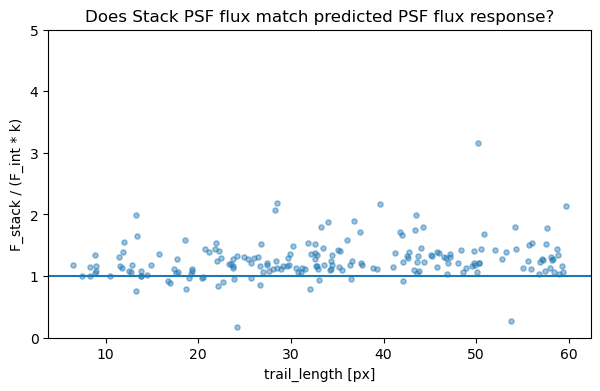

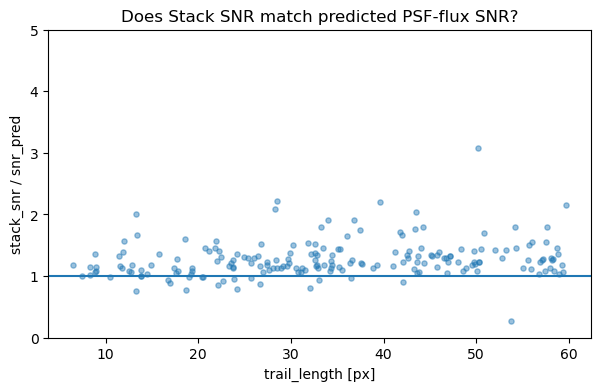

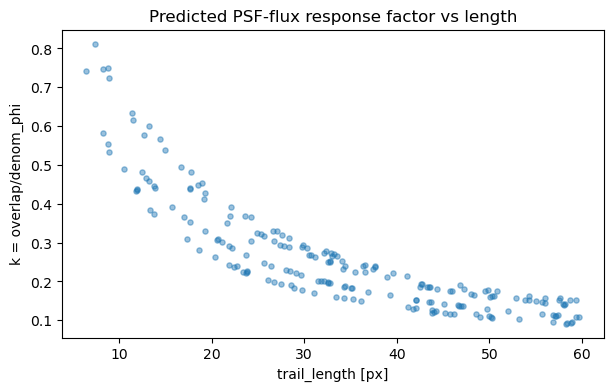

In [33]:
plt.figure(figsize=(7,4))
plt.scatter(R["L"], R["flux_ratio_stack_over_pred"], s=14, alpha=0.45)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("F_stack / (F_int * k)")
plt.ylim(0,5)
plt.title("Does Stack PSF flux match predicted PSF flux response?")
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(R["L"], R["snr_ratio_stack_over_pred"], s=14, alpha=0.45)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / snr_pred")
plt.ylim(0,5)
plt.title("Does Stack SNR match predicted PSF-flux SNR?")
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(R["L"], R["k"], s=14, alpha=0.45)
plt.xlabel("trail_length [px]")
plt.ylabel("k = overlap/denom_phi")
plt.title("Predicted PSF-flux response factor vs length")
plt.show()


In [34]:
# Cell 1 — Build the empirical correction dataset:  C(L) = stack_snr / snr_model_raw
# Assumes you already have:
#   - d : pandas DataFrame with columns ['x','y','trail_length','beta','integrated_mag','stack_snr','visit','detector']
#   - get_calexp_for_row(row) -> (calexp, datasetRef/None)
#   - psf_fit_flux_sigma(calexp, x, y, L_pix, theta_deg, use_kernel_image, pad_sigma, step)
#
# Output:
#   dfC with columns: L, ratio, logL, etc.

import numpy as np
import pandas as pd
from collections import Counter

def model_snr_from_mag(calexp, mag, sigmaF):
    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))
    return F / float(sigmaF)

N = min(800, len(d))  # increase if you want; butler I/O dominates
ss = d.sample(n=N, random_state=1).copy()

why = Counter()
rows = []
for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag_int = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if not (np.isfinite(sigmaF) and sigmaF > 0):
            why["sigmaF_bad"] += 1
            continue

        snr_model = model_snr_from_mag(calexp, mag_int, sigmaF)
        if not (np.isfinite(snr_model) and snr_model > 0):
            why["snr_model_bad"] += 1
            continue

        ratio = stack_snr / snr_model  # empirical correction factor
        if not (np.isfinite(ratio) and ratio > 0):
            why["ratio_bad"] += 1
            continue

        rows.append((L, ratio))
        why["ok"] += 1

    except Exception:
        why["exception"] += 1

print("Counts:", dict(why))

dfC = pd.DataFrame(rows, columns=["L", "ratio"])
dfC = dfC[(dfC["L"] > 0) & np.isfinite(dfC["ratio"]) & (dfC["ratio"] > 0)].copy()
dfC["logL"] = np.log1p(dfC["L"])

print("Rows kept:", len(dfC))
print(dfC.describe(percentiles=[0.05,0.5,0.95]))


Counts: {'ok': 313}
Rows kept: 313
                L       ratio        logL
count  313.000000  313.000000  313.000000
mean    33.533504    2.639378    3.431219
std     14.597390   13.332441    0.505194
min      6.474348    0.276301    2.011477
5%       9.864767    0.944373    2.385521
50%     32.900477    1.220958    3.523429
95%     57.635967    2.055057    4.071348
max     59.711341  197.360291    4.106131


Fit A (power-sat) params [a, b, L0, pwr] = [ 1.12746468  0.16618154 26.68594499  5.0196391 ]
Residual median: -0.01762453027825117
Residual MAD:    0.12897778221872258


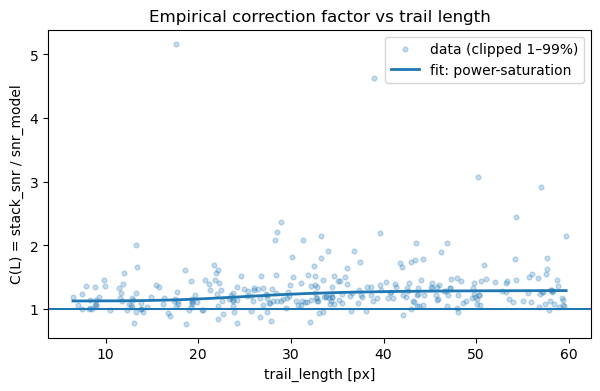

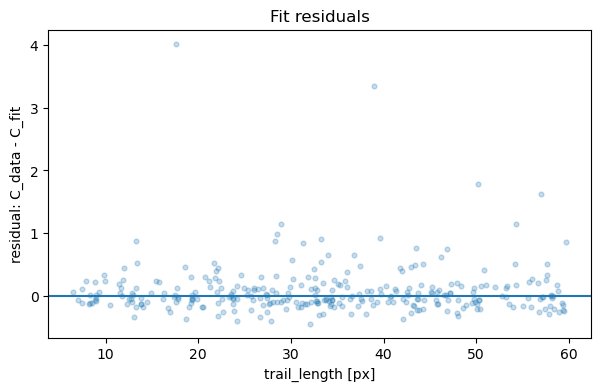

In [36]:
# Cell 2 — Robust parametric fit for C(L)
# We fit a smooth monotonic-ish function. Two good options:
#   (A) "power-saturation": C(L) = a + b * (L/L0)^p / (1 + (L/L0)^p)
#   (B) "rational-2/2":     C(L) = (a0 + a1 L + a2 L^2) / (1 + b1 L + b2 L^2)
#
# Uses robust loss (soft_l1) to reduce outlier influence.
# Produces:
#   - best-fit params
#   - a callable C_hat(L)
#   - plots: scatter + fitted curve, residuals vs L
#
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.optimize import least_squares
except Exception as e:
    raise RuntimeError("scipy is required for robust fitting in this cell.") from e

L = dfC["L"].to_numpy(dtype=float)
y = dfC["ratio"].to_numpy(dtype=float)

# Optional: clip extreme ratios (keeps fit sane if a few outliers exist)
q_lo, q_hi = np.percentile(y, [1, 99])
mask = (y >= q_lo) & (y <= q_hi)
L2, y2 = L[mask], y[mask]

# ---- Option A: power-saturation model (recommended) ----
def C_pow_sat(L, p):
    a, b, L0, pwr = p
    L0 = np.clip(L0, 1e-3, np.inf)
    pwr = np.clip(pwr, 1e-3, 10.0)
    x = (L / L0) ** pwr
    return a + b * (x / (1.0 + x))

def resid_pow_sat(p):
    return C_pow_sat(L2, p) - y2

# Initial guess from your observed medians: baseline ~1.1–1.3, high-L ~1.4–1.5
p0 = np.array([1.05, 0.50, 30.0, 2.0], dtype=float)  # a, b, L0, pwr
lb = np.array([0.5,  0.0,  1.0,  0.2])
ub = np.array([3.0,  5.0,  200.0, 6.0])

sol = least_squares(resid_pow_sat, p0, bounds=(lb, ub), loss="soft_l1", f_scale=0.10)
p_hat = sol.x
print("Fit A (power-sat) params [a, b, L0, pwr] =", p_hat)

def C_hat(Lin):
    Lin = np.asarray(Lin, float)
    return C_pow_sat(Lin, p_hat)

# Diagnostics
yhat = C_hat(L2)
res  = y2 - yhat
print("Residual median:", np.median(res))
print("Residual MAD:   ", np.median(np.abs(res - np.median(res))))

# Plots
Lgrid = np.linspace(L2.min(), L2.max(), 300)

plt.figure(figsize=(7,4))
plt.scatter(L2, y2, s=12, alpha=0.25, label="data (clipped 1–99%)")
plt.plot(Lgrid, C_hat(Lgrid), lw=2, label="fit: power-saturation")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("C(L) = stack_snr / snr_model")
plt.legend()
plt.title("Empirical correction factor vs trail length")
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(L2, res, s=12, alpha=0.25)
plt.axhline(0.0)
plt.xlabel("trail_length [px]")
plt.ylabel("residual: C_data - C_fit")
plt.title("Fit residuals")
plt.show()
